CT2 TRAINING:
- 1JHN DONE (-1.55)
- 2JHN DONE (-2.65)
- 3JHN DONE (-2.96)
- 2JHH DONE (-2.66)
- 3JHH DONE (-2.93)
- 1JHC

CT2 NF TRAINING:
- 1JHN DONE (-1.55)
- 1JHC DONE (-1.38) (~100 epoch left)
- 2JHN DONE (-2.99)
- 2JHH DONE (-3.14) (45 epoch left) (forgot to save this model!!)
- 2JHC DONE (-2.60) (B2 & 120 epoch left)
- 3JHN DONE (-3.25)
- 3JHH
- 3JHC DONE (-1.93)

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pickle, numba, torch, tqdm, random, utils, os, gc, time
import networkx as nx
import gc, psutil
from collections import OrderedDict, defaultdict
from copy import deepcopy

from opt import RAdam
from rdkit.Chem.AtomPairs.Utils import NumPiElectrons
from rdkit.Chem.rdMolTransforms import GetAngleRad, GetBondLength
from rdkit.Chem.rdchem import Atom, Bond
from rdkit.Chem.AtomPairs.Pairs import rdMolDescriptors as rdmd
from rdkit import Chem, RDConfig
from rdkit.Chem import ChemicalFeatures

import torch_geometric.transforms as T
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, GRU, BatchNorm1d, Dropout, SELU
from torch_geometric.data import Data
from torch_geometric.nn import NNConv, Set2Set, GATConv
from torch_geometric.data import DataLoader


%config InlineBackend.figure_format ='retina'

In [3]:
train = pd.read_csv('train.csv')
structures = pd.read_csv("structures.csv")

In [4]:
gratio = pd.DataFrame({"atom":["H","C","N","O","F"],
                       "Gratio": [42.576,10.705,-4.316,-5.772,40.060],
                       "Eneg": [2.2,2.55,3.04,3.44,3.98],
                       "radius":[110,170,155,152,147],
                       "atomic_num":[1,6,7,8,9],
                       "numv":[1,4,5,6,7]})
structures = structures.merge(gratio,how='left',on='atom')

In [5]:
train = train.groupby('type').get_group('3JHN')

In [6]:
t2 = pd.read_csv('train.csv')
t2 = t2[t2['molecule_name'].isin(train['molecule_name'])]
t2.drop(['id','type','scalar_coupling_constant'],axis=1,inplace=True)

In [7]:
from collections import defaultdict
molcouples = defaultdict(list)
cpv = t2.values.tolist()
for c in tqdm.tqdm_notebook(cpv):
    molcouples[c[0]].append((c[1],c[2]))

In [8]:
train.drop('type',axis=1,inplace=True)

In [9]:
train = utils.map_atom_info(train,0,structures)
train = utils.map_atom_info(train,1,structures)

In [10]:
with open('rdkitmolecules.p', 'rb') as fp:
    d = pickle.load(fp)

In [11]:
tf = train.groupby('molecule_name')

In [12]:
groups = list(tf.groups.keys())

In [13]:
len(groups)

45774

In [14]:
with open("trainmols3JHN.txt", "rb") as fp:   # Unpickling
    trainmols = pickle.load(fp)    
with open("valmols3JHN.txt", "rb") as fp:   # Unpickling
    valmols = pickle.load(fp)    

In [15]:
len(trainmols)+len(valmols)

45774

In [16]:
len(trainmols)

41197

In [17]:
len(valmols)

4577

In [18]:
tc = []
vc = [] 
for i in tqdm.tqdm_notebook(trainmols):
    g = tf.get_group(i)
    tc.append(g)
for i in tqdm.tqdm_notebook(valmols):
    g = tf.get_group(i)
    vc.append(g)

In [19]:
train = pd.concat(tc)

In [20]:
print(len(train),train['molecule_name'].nunique())

149749 41197


In [21]:
val = pd.concat(vc)

In [22]:
print(len(val),val['molecule_name'].nunique())

16666 4577


In [23]:
molnames = list(train['molecule_name'].unique())
mols = OrderedDict()

for name in molnames:
    mols[name] = d[name]
    
struct =  structures[structures['molecule_name'].isin(molnames)]
g = struct.groupby('molecule_name')

struct.head()

,molecule_name,atom_index,atom,x,y,z,Gratio,Eneg,radius,atomic_num,numv
40,dsgdb9nsd_000010,0,C,-0.017886,1.467128,0.010113,10.705,2.55,170,6,4
41,dsgdb9nsd_000010,1,C,0.001738,0.010353,0.002076,10.705,2.55,170,6,4
42,dsgdb9nsd_000010,2,N,0.017652,-1.144529,-0.004204,-4.316,3.04,155,7,5
43,dsgdb9nsd_000010,3,H,1.002029,1.860899,0.002454,42.576,2.20,110,1,1
44,dsgdb9nsd_000010,4,H,-0.543988,1.844799,-0.870755,42.576,2.20,110,1,1


In [24]:
struct['molecule_name'].nunique()

41197

In [25]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)

In [26]:
atfn = {'Acceptor':0,
         'Aromatic':1,
         'Donor':2,
         'Hydrophobe':3,
         'LumpedHydrophobe':4,
         'NegIonizable':5,
         'PosIonizable':6,
         'ZnBinder':7}

In [27]:
#ADD DISTANCE TO TARGET FEATURE
def getAtomNodeFeats(molname, mols, data):
    symbol, x, y, z, gr,eneg,radius,atomnum,nv = 2,3,4,5,6,7,8,9,10
    mol = mols[molname]
    feats = factory.GetFeaturesForMol(mol)
    atfdict = defaultdict(list)
    for i in range(len(feats)):
        fam = feats[i].GetFamily()
        dl = feats[i].GetAtomIds()
        for aid in dl:
            atfdict[aid].append(fam)
    
    l = len(data)
    nodef = []
    
    eems = rdmd.CalcEEMcharges(mol)
    spfd = {'S':0,'SP':0.5,'SP2':1/3,'SP3':1/4}
    
    for i in range(l):
        d = data[i]
        atom = mol.GetAtomWithIdx(i)
        ahyb =  str(atom.GetHybridization())
        sym = d[symbol]
        hf = 'NONE'
        if i in atfdict:
            hf = atfdict[i]
        ff = [sym=='H',sym=='C',sym=='N',sym=='O',sym=='F',d[atomnum],(int)(atom.IsInRing() == True),
              ahyb=='S',ahyb=='SP', ahyb=='SP2', ahyb=='SP3',d[x],d[y],d[z],eems[i],spfd[ahyb],
              d[radius],d[eneg],d[gr],NumPiElectrons(atom),0,0]
        ff += ([0]*135)#        #AT3 FEATS   -24,-12
        #AT4 FEATS -34,-25
        newf = [0,0,0,0,0,0,0,0,  0,0,0,0,0,0,0,0,0,0,     0,0,0,0,0,0,0,0,0,0,0,0,0,  0, 0,0,0,0,0,0,0,0,0,0]
        newf[-11] = d[nv]
        if hf != 'NONE':
            for t in hf:
                newf[atfn[t]] = 1
            
        ff += newf
        nodef.append(ff)
    
    lm = molcouples[molname]
    for i,(a0,a1) in enumerate(lm):
        nodef[a0][22+i] = 1
        nodef[a1][22+i] = 1
    return nodef

In [28]:
#NODEF
#-34: dist at4
#-33: angle at4
#-32: cos at4
#-31: sin at4
#-30: angle m2
#-29: cos m2
#-28: sin m2
#-27: X
#-26: Y
#-25: Z

In [29]:
@numba.jit(nopython=True)
def getAngle(x0,y0,z0,x1,y1,z1):
    mag_x0 = np.sqrt(x0**2 + y0**2 + z0**2)
    mag_x1 = np.sqrt(x1**2 + y1**2 + z1**2)
    dotp = (x0*x1) + (y0* y1) + (z0*z1)
    c = dotp/(mag_x0*mag_x1)
    if c < -1:
        c = -1
    elif c > 1:
        c = 1
    theta = np.arccos(c)
    return theta, np.cos(theta), np.sin(theta)

In [30]:
def getBondEdgeFeats(molname, mols, data):
    x, y, z = 3,4,5
    mol = mols[molname]
    bonds = mol.GetBonds()
    src,dst = [],[]
    bondf = []
    aed = defaultdict(list)
    
    btd = {'AROMATIC':0,'SINGLE':1,'DOUBLE':2, 'TRIPLE':3}
    #make bidirectional
    for bond in bonds:
        id0,id1 = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        
        src.append(id0)
        dst.append(id1)
        src.append(id1)
        dst.append(id0)
        
        aed[id0].append(id1)
        aed[id1].append(id0)
        
        t0,t1 = data[id0],data[id1]
        x0,y0,z0,x1,y1,z1 = t0[x],t0[y],t0[z],t1[x],t1[y],t1[z]   
                
        d = GetBondLength(mol.GetConformer(),id0,id1)
        a,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
        isconj = (int)(bond.GetIsConjugated() == True)
        btype =  str(bond.GetBondType())
        bt = [0,0,0,0]
        bt[btd[btype]] = 1
        #angle t0, cos t0, sin t0, angle t1, cos t1, sin t1, angle tv, cos tv, sin tv
        # -16,-10
        # -22,-17
        ff = [d,a,cos,sin,isconj] + bt + [0,0,0,0,0,0] + [0,0,0,0,0,0,0] + [0,0,0,0,0,0,0,0,0]
        bondf.append(ff)
        bondf.append(ff)
        #[blen,angle,cos,sin,isconj,bt,bt,bt,bt]
    edge_index = []
    edge_index.append(src)
    edge_index.append(dst)
    #tonorm: 0,1,2,3,4
    return bondf, edge_index, aed    

In [31]:
#-22: angle at4
#-21: cos at4
#-20: sin at4
#-19: angle m2
#-18: cos m2
#-17: sin m2


In [32]:
mnames = list(mols.keys())

datadir = {}
for name in tqdm.tqdm_notebook(mnames):
    a = g.get_group(name)
    nodef = getAtomNodeFeats(name,mols,a.values.tolist())
    bondf, edgeidx, aed = getBondEdgeFeats(name,mols,a.values.tolist())
    datadir[name] = [nodef, bondf, edgeidx, aed]

In [33]:
train= train.drop(['atom_0', 'x_0', 'y_0', 'z_0', 'Gratio_x',
            'Eneg_x', 'radius_x', 'atomic_num_x', 'atom_1', 'x_1', 'y_1', 'z_1',
            'Gratio_y', 'Eneg_y', 'radius_y', 'atomic_num_y'],axis=1)

In [34]:
train = train.drop(['numv_x','numv_y'],axis=1)

In [35]:
t = train.values.tolist()

In [36]:
@numba.jit(nopython=True)
def getDist(x0,y0,z0,x1,y1,z1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2 + (z0-z1)**2)

In [37]:
olds = np.seterr(all='raise')

In [38]:
trainlist = []
l = len(t)
for ii,dp in enumerate(tqdm.tqdm_notebook(t)):
    name, id0, id1, y = dp[1], dp[2], dp[3], dp[4]
    if name != 'dsgdb9nsd_059827':
        n,b,e,aed = datadir[name]
        nodef,bondf,edgeidx = np.array(n), np.array(b), np.array(e)
        nodef,bondf,edgeidx = nodef.tolist(),bondf.tolist(),edgeidx.tolist()

        nodef[id0][-1] = 1
        nodef[id1][-1] = 1

        nid0 = nodef[id0]
        nid1 = nodef[id1]
        x0,y0,z0 = nid0[11],nid0[12],nid0[13]
        x1,y1,z1 = nid1[11],nid1[12],nid1[13]

        ll = len(nodef)
        ai0 = aed[id0]
        ai1 = aed[id1]

        G = nx.Graph()
        eds = [x for x in zip(edgeidx[0],edgeidx[1])]
        G.add_edges_from(eds)
        sp = nx.dijkstra_path(G,id0,id1)

        if len(sp) == 4:
            mp1 = sp[1]
            mp2 = sp[2]
            
            nodef[mp1][-1] = 1
            nodef[mp2][-1] = 1
            
            tnm1 = nodef[mp1]
            tnm2 = nodef[mp2]
            
            xa1,ya1,za1 = tnm1[11],tnm1[12],tnm1[13]
            xa2,ya2,za2 = tnm2[11],tnm2[12],tnm2[13]
            
            xm0,ym0,zm0 = xa1-x0,ya1-y0,za1-z0
            xm1,ym1,zm1 = xa2-xa1,ya2-ya1,za2-za1
            xm2,ym2,zm2 = x1-xa2,y1-ya2,z1-za2
            for i in range(ll):
                if i not in ai0 and i != id0:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x0,y0,z0)
                    theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id0)

                    edgeidx[0].append(id0)
                    edgeidx[1].append(i)
                if i not in ai1 and  i != id1:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x1,y1,z1)
                    theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id1)

                    edgeidx[0].append(id1)
                    edgeidx[1].append(i)
                    
            G = nx.Graph()
            eds = [x for x in zip(edgeidx[0],edgeidx[1])]
            G.add_edges_from(eds)
            for i in range(ll):
                if (not G.has_edge(i,mp1)) and i != mp1:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,xa1,ya1,za1)
                    theta,cos,sin = getAngle(xi,yi,zi,xa1,ya1,za1)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(mp1)

                    edgeidx[0].append(mp1)
                    edgeidx[1].append(i)
                if (not G.has_edge(i,mp2)) and i != mp2:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,xa2,ya2,za2)
                    theta,cos,sin = getAngle(xi,yi,zi,xa2,ya2,za2)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(mp2)

                    edgeidx[0].append(mp2)
                    edgeidx[1].append(i)

            bonds = [x for x in zip(edgeidx[0],edgeidx[1])]
            intbonds = [(id0,mp1),(mp1,mp2),(mp2,id1),(mp1,id0),(mp2,mp1),(id1,mp2)]
            for i,bf in enumerate(bondf):
                i0,i1 = bonds[i]
                if (i0,i1) in intbonds:
                    bf[-10] = 1
                nfa,nfb = nodef[i0],nodef[i1]
                xa,ya,za = nfa[11],nfa[12],nfa[13]
                xb,yb,zb = nfb[11],nfb[12],nfb[13]
                xi,yi,zi = xa-xb,ya-yb,za-zb
                #xi,yi,zi is bond vector
                a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)#ang tatom 0
                a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)#ang tatom 1
                
                am1,cosm1,sinm1 = getAngle(xi,yi,zi,xa1,ya1,za1) #ang mpatom 1
                am2,cosm2,sinm2 = getAngle(xi,yi,zi,xa2,ya2,za2) #ang mpatom 2
                
                av0,cosv0,sinv0 = getAngle(xi,yi,zi,xm0,ym0,zm0)
                av1,cosv1,sinv1 = getAngle(xi,yi,zi,xm1,ym1,zm1)
                av2,cosv2,sinv2 = getAngle(xi,yi,zi,xm2,ym2,zm2)
                
                bf[-22] = a0
                bf[-21] = cos0
                bf[-20] = sin0
                bf[-19] = a1
                bf[-18] = cos1
                bf[-17] = sin1
                #CONTINUE FROM HERE
                bf[-16] = am1
                bf[-15] = cosm1
                bf[-14] = sinm1
                bf[-13] = am2
                bf[-12] = cosm2
                bf[-11] = sinm2
                
                bf[-9] = av0
                bf[-8] = cosv0
                bf[-7] = sinv0
                bf[-6] = av1
                bf[-5] = cosv1
                bf[-4] = sinv1
                bf[-3] = av2
                bf[-2] = cosv2
                bf[-1] = sinv2
                
            for i,nf in enumerate(nodef):
                if i == mp1:
                    nf[20] = getDist(x0,y0,z0,xa1,ya1,za1)
                    nf[21] = getDist(x1,y1,z1,xa1,ya1,za1)
                    
                    nf[-34] = 0#dist mpat1
                    nf[-33] = 0#angle 
                    nf[-32] = 1#cos
                    nf[-31] = 0#sin
                    theta,cos,sin = getAngle(xa1,ya1,za1,xa2,ya2,za2)
                    dist = getDist(xa1,ya1,za1,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(xa1,ya1,za1,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(xa1,ya1,za1,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(xa1,ya1,za1,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = 0#rel to mat1
                    nf[-16] = 0
                    nf[-15] = 0
                    
                    nf[-14] = xa2-xa1#rel to mat2
                    nf[-13] = ya2-ya1
                    nf[-12] = za2-za1
                    
                    theta,cos,sin = getAngle(xa1,ya1,za1,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    theta,cos,sin = getAngle(xa1,ya1,za1,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-xa1
                    nf[-9] = y1-ya1
                    nf[-8] = z1-za1#xyz rel to at1
                    nf[11] = x0-xa1
                    nf[12] = y0-ya1
                    nf[13] = z0-za1#xyz rel to at0
                elif i == mp2:
                    nf[20] = getDist(x0,y0,z0,xa2,ya2,za2)
                    nf[21] = getDist(x1,y1,z1,xa2,ya2,za2)
                    
                    theta,cos,sin = getAngle(xa2,ya2,za2,xa1,ya1,za1)
                    dist = getDist(xa2,ya2,za2,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    
                    nf[-30] = 0#dist mpat2
                    nf[-29] = 0#angle 
                    nf[-28] = 1#cos
                    nf[-27] = 0#sin
                    theta,cos,sin = getAngle(xa2,ya2,za2,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(xa2,ya2,za2,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(xa2,ya2,za2,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-xa2#rel to mat1
                    nf[-16] = ya1-ya2
                    nf[-15] = za1-za2
                    
                    nf[-14] = 0#rel to mat2
                    nf[-13] = 0
                    nf[-12] = 0
                    
                    theta,cos,sin = getAngle(xa2,ya2,za2,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    theta,cos,sin = getAngle(xa2,ya2,za2,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-xa2
                    nf[-9] = y1-ya2
                    nf[-8] = z1-za2#xyz rel to at1
                    nf[11] = x0-xa2
                    nf[12] = y0-ya2
                    nf[13] = z0-za2#xyz rel to at0
                elif i == id0:
                    nf[20] = 0
                    nf[21] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    theta,cos,sin = getAngle(x0,y0,z0,xa1,ya1,za1)
                    dist = getDist(x0,y0,z0,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    theta,cos,sin = getAngle(x0,y0,z0,xa2,ya2,za2)
                    dist = getDist(x0,y0,z0,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(x0,y0,z0,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(x0,y0,z0,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(x0,y0,z0,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-x0#rel to mat1
                    nf[-16] = ya1-y0
                    nf[-15] = za1-z0
                    
                    nf[-14] = xa2-x0#rel to mat2
                    nf[-13] = ya2-y0
                    nf[-12] = za2-z0
                    
                    nf[-7] = 0 #angle with at0
                    nf[-6] = 1 #cos with at0
                    nf[-5] = 0 #sin with at0
                    theta,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-x0
                    nf[-9] = y1-y0
                    nf[-8] = z1-z0#xyz rel to at1
                    nf[11] = 0
                    nf[12] = 0
                    nf[13] = 0#xyz rel to at0

                elif i == id1:
                    nf[21] = 0
                    nf[20] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    theta,cos,sin = getAngle(x1,y1,z1,xa1,ya1,za1)
                    dist = getDist(x1,y1,z1,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    theta,cos,sin = getAngle(x1,y1,z1,xa2,ya2,za2)
                    dist = getDist(x1,y1,z1,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(x1,y1,z1,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(x1,y1,z1,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(x1,y1,z1,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-x1#rel to mat1
                    nf[-16] = ya1-y1
                    nf[-15] = za1-z1
                    
                    nf[-14] = xa2-x1#rel to mat2
                    nf[-13] = ya2-y1
                    nf[-12] = za2-z1
                    theta,cos,sin = getAngle(x1,y1,z1,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    
                    nf[-4] = 0 #angle with at1
                    nf[-3] = 1 #cos with at1
                    nf[-2] = 0 #sin with at1
                    
                    nf[-10] = 0
                    nf[-9] = 0
                    nf[-8] = 0#xyz rel to at1
                    nf[11] = x0-x1
                    nf[12] = y0-y1
                    nf[13] = z0-z1#xyz rel to at0
                else:
                    xi,yi,zi = nf[11],nf[12],nf[13]
                    nf[21] = getDist(xi,yi,zi,x1,y1,z1)
                    nf[20] = getDist(xi,yi,zi,x0,y0,z0)
                    
                    theta,cos,sin = getAngle(xi,yi,zi,xa1,ya1,za1)
                    dist = getDist(xi,yi,zi,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    theta,cos,sin = getAngle(xi,yi,zi,xa2,ya2,za2)
                    dist = getDist(xi,yi,zi,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(xi,yi,zi,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(xi,yi,zi,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(xi,yi,zi,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-xi#rel to mat1
                    nf[-16] = ya1-yi
                    nf[-15] = za1-zi
                    
                    nf[-14] = xa2-xi#rel to mat2
                    nf[-13] = ya2-yi
                    nf[-12] = za2-zi
                    theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-xi
                    nf[-9] = y1-yi
                    nf[-8] = z1-zi#xyz rel to at1
                    nf[11] = x0-xi
                    nf[12] = y0-yi
                    nf[13] = z0-zi#xyz rel to at0

            x = torch.tensor(nodef, dtype=torch.float)
            edge_index = torch.tensor(edgeidx, dtype=torch.long)
            edge_attr = torch.tensor(bondf,dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y)

            trainlist.append(data)

In [39]:
val= val.drop(['atom_0', 'x_0', 'y_0', 'z_0', 'Gratio_x',
            'Eneg_x', 'radius_x', 'atomic_num_x', 'atom_1', 'x_1', 'y_1', 'z_1',
            'Gratio_y', 'Eneg_y', 'radius_y', 'atomic_num_y','numv_x','numv_y'],axis=1)

In [40]:
v = val.values.tolist()

In [41]:
molnames = list(val['molecule_name'].unique())
mols = OrderedDict()
for name in molnames:
    mols[name] = d[name]
struct =  structures[structures['molecule_name'].isin(molnames)]
g = struct.groupby('molecule_name')
struct.head()

,molecule_name,atom_index,atom,x,y,z,Gratio,Eneg,radius,atomic_num,numv
230,dsgdb9nsd_000034,0,O,-0.037382,1.445478,0.010108,-5.772,3.44,152,8,6
231,dsgdb9nsd_000034,1,C,0.012929,0.034417,0.002092,10.705,2.55,170,6,4
232,dsgdb9nsd_000034,2,C,-1.357475,-0.488745,0.012397,10.705,2.55,170,6,4
233,dsgdb9nsd_000034,3,N,-2.421353,-0.936852,0.020161,-4.316,3.04,155,7,5
234,dsgdb9nsd_000034,4,H,0.868981,1.769729,0.004176,42.576,2.20,110,1,1


In [42]:
mnames = list(mols.keys())
datadir = {}
for name in tqdm.tqdm_notebook(mnames):
    a = g.get_group(name)
    nodef = getAtomNodeFeats(name,mols,a.values.tolist())
    bondf, edgeidx, aed = getBondEdgeFeats(name,mols,a.values.tolist())
    datadir[name] = [nodef, bondf, edgeidx, aed]

In [43]:
vallist = []
l = len(v)
for dp in tqdm.tqdm_notebook(v):
    name, id0, id1, y = dp[1], dp[2], dp[3], dp[4]
    if name != 'dsgdb9nsd_059827':
        n,b,e,aed = datadir[name]
        nodef,bondf,edgeidx = np.array(n), np.array(b), np.array(e)
        nodef,bondf,edgeidx = nodef.tolist(),bondf.tolist(),edgeidx.tolist()

        nodef[id0][-1] = 1
        nodef[id1][-1] = 1

        nid0 = nodef[id0]
        nid1 = nodef[id1]
        x0,y0,z0 = nid0[11],nid0[12],nid0[13]
        x1,y1,z1 = nid1[11],nid1[12],nid1[13]

        ll = len(nodef)
        ai0 = aed[id0]
        ai1 = aed[id1]

        G = nx.Graph()
        eds = [x for x in zip(edgeidx[0],edgeidx[1])]
        G.add_edges_from(eds)
        sp = nx.dijkstra_path(G,id0,id1)

        if len(sp) == 4:
            mp1 = sp[1]
            mp2 = sp[2]
            
            nodef[mp1][-1] = 1
            nodef[mp2][-1] = 1
            
            tnm1 = nodef[mp1]
            tnm2 = nodef[mp2]
            
            xa1,ya1,za1 = tnm1[11],tnm1[12],tnm1[13]
            xa2,ya2,za2 = tnm2[11],tnm2[12],tnm2[13]
            
            xm0,ym0,zm0 = xa1-x0,ya1-y0,za1-z0
            xm1,ym1,zm1 = xa2-xa1,ya2-ya1,za2-za1
            xm2,ym2,zm2 = x1-xa2,y1-ya2,z1-za2
            for i in range(ll):
                if i not in ai0 and i != id0:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x0,y0,z0)
                    theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id0)

                    edgeidx[0].append(id0)
                    edgeidx[1].append(i)
                if i not in ai1 and  i != id1:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,x1,y1,z1)
                    theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(id1)

                    edgeidx[0].append(id1)
                    edgeidx[1].append(i)
                    
            G = nx.Graph()
            eds = [x for x in zip(edgeidx[0],edgeidx[1])]
            G.add_edges_from(eds)
            for i in range(ll):
                if (not G.has_edge(i,mp1)) and i != mp1:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,xa1,ya1,za1)
                    theta,cos,sin = getAngle(xi,yi,zi,xa1,ya1,za1)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(mp1)

                    edgeidx[0].append(mp1)
                    edgeidx[1].append(i)
                if (not G.has_edge(i,mp2)) and i != mp2:
                    temp = [0]*31
                    tnf = nodef[i]
                    xi,yi,zi = tnf[11],tnf[12],tnf[13]
                    temp[0] = getDist(xi,yi,zi,xa2,ya2,za2)
                    theta,cos,sin = getAngle(xi,yi,zi,xa2,ya2,za2)
                    temp[1] = theta
                    temp[2] = cos
                    temp[3] = sin

                    bondf.append(temp)
                    bondf.append(temp)

                    edgeidx[0].append(i)
                    edgeidx[1].append(mp2)

                    edgeidx[0].append(mp2)
                    edgeidx[1].append(i)

            bonds = [x for x in zip(edgeidx[0],edgeidx[1])]
            intbonds = [(id0,mp1),(mp1,mp2),(mp2,id1),(mp1,id0),(mp2,mp1),(id1,mp2)]
            for i,bf in enumerate(bondf):
                i0,i1 = bonds[i]
                if (i0,i1) in intbonds:
                    bf[-10] = 1
                nfa,nfb = nodef[i0],nodef[i1]
                xa,ya,za = nfa[11],nfa[12],nfa[13]
                xb,yb,zb = nfb[11],nfb[12],nfb[13]
                xi,yi,zi = xa-xb,ya-yb,za-zb
                #xi,yi,zi is bond vector
                a0,cos0,sin0 = getAngle(xi,yi,zi,x0,y0,z0)#ang tatom 0
                a1,cos1,sin1 = getAngle(xi,yi,zi,x1,y1,z1)#ang tatom 1
                
                am1,cosm1,sinm1 = getAngle(xi,yi,zi,xa1,ya1,za1) #ang mpatom 1
                am2,cosm2,sinm2 = getAngle(xi,yi,zi,xa2,ya2,za2) #ang mpatom 2
                
                av0,cosv0,sinv0 = getAngle(xi,yi,zi,xm0,ym0,zm0)
                av1,cosv1,sinv1 = getAngle(xi,yi,zi,xm1,ym1,zm1)
                av2,cosv2,sinv2 = getAngle(xi,yi,zi,xm2,ym2,zm2)
                
                bf[-22] = a0
                bf[-21] = cos0
                bf[-20] = sin0
                bf[-19] = a1
                bf[-18] = cos1
                bf[-17] = sin1
                #CONTINUE FROM HERE
                bf[-16] = am1
                bf[-15] = cosm1
                bf[-14] = sinm1
                bf[-13] = am2
                bf[-12] = cosm2
                bf[-11] = sinm2
                
                bf[-9] = av0
                bf[-8] = cosv0
                bf[-7] = sinv0
                bf[-6] = av1
                bf[-5] = cosv1
                bf[-4] = sinv1
                bf[-3] = av2
                bf[-2] = cosv2
                bf[-1] = sinv2
                
            for i,nf in enumerate(nodef):
                if i == mp1:
                    nf[20] = getDist(x0,y0,z0,xa1,ya1,za1)
                    nf[21] = getDist(x1,y1,z1,xa1,ya1,za1)
                    
                    nf[-34] = 0#dist mpat1
                    nf[-33] = 0#angle 
                    nf[-32] = 1#cos
                    nf[-31] = 0#sin
                    theta,cos,sin = getAngle(xa1,ya1,za1,xa2,ya2,za2)
                    dist = getDist(xa1,ya1,za1,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(xa1,ya1,za1,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(xa1,ya1,za1,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(xa1,ya1,za1,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = 0#rel to mat1
                    nf[-16] = 0
                    nf[-15] = 0
                    
                    nf[-14] = xa2-xa1#rel to mat2
                    nf[-13] = ya2-ya1
                    nf[-12] = za2-za1
                    
                    theta,cos,sin = getAngle(xa1,ya1,za1,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    theta,cos,sin = getAngle(xa1,ya1,za1,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-xa1
                    nf[-9] = y1-ya1
                    nf[-8] = z1-za1#xyz rel to at1
                    nf[11] = x0-xa1
                    nf[12] = y0-ya1
                    nf[13] = z0-za1#xyz rel to at0
                elif i == mp2:
                    nf[20] = getDist(x0,y0,z0,xa2,ya2,za2)
                    nf[21] = getDist(x1,y1,z1,xa2,ya2,za2)
                    
                    theta,cos,sin = getAngle(xa2,ya2,za2,xa1,ya1,za1)
                    dist = getDist(xa2,ya2,za2,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    
                    nf[-30] = 0#dist mpat2
                    nf[-29] = 0#angle 
                    nf[-28] = 1#cos
                    nf[-27] = 0#sin
                    theta,cos,sin = getAngle(xa2,ya2,za2,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(xa2,ya2,za2,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(xa2,ya2,za2,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-xa2#rel to mat1
                    nf[-16] = ya1-ya2
                    nf[-15] = za1-za2
                    
                    nf[-14] = 0#rel to mat2
                    nf[-13] = 0
                    nf[-12] = 0
                    
                    theta,cos,sin = getAngle(xa2,ya2,za2,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    theta,cos,sin = getAngle(xa2,ya2,za2,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-xa2
                    nf[-9] = y1-ya2
                    nf[-8] = z1-za2#xyz rel to at1
                    nf[11] = x0-xa2
                    nf[12] = y0-ya2
                    nf[13] = z0-za2#xyz rel to at0
                elif i == id0:
                    nf[20] = 0
                    nf[21] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    theta,cos,sin = getAngle(x0,y0,z0,xa1,ya1,za1)
                    dist = getDist(x0,y0,z0,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    theta,cos,sin = getAngle(x0,y0,z0,xa2,ya2,za2)
                    dist = getDist(x0,y0,z0,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(x0,y0,z0,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(x0,y0,z0,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(x0,y0,z0,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-x0#rel to mat1
                    nf[-16] = ya1-y0
                    nf[-15] = za1-z0
                    
                    nf[-14] = xa2-x0#rel to mat2
                    nf[-13] = ya2-y0
                    nf[-12] = za2-z0
                    
                    nf[-7] = 0 #angle with at0
                    nf[-6] = 1 #cos with at0
                    nf[-5] = 0 #sin with at0
                    theta,cos,sin = getAngle(x0,y0,z0,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-x0
                    nf[-9] = y1-y0
                    nf[-8] = z1-z0#xyz rel to at1
                    nf[11] = 0
                    nf[12] = 0
                    nf[13] = 0#xyz rel to at0

                elif i == id1:
                    nf[21] = 0
                    nf[20] = getDist(x0,y0,z0,x1,y1,z1)
                    
                    theta,cos,sin = getAngle(x1,y1,z1,xa1,ya1,za1)
                    dist = getDist(x1,y1,z1,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    theta,cos,sin = getAngle(x1,y1,z1,xa2,ya2,za2)
                    dist = getDist(x1,y1,z1,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(x1,y1,z1,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(x1,y1,z1,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(x1,y1,z1,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-x1#rel to mat1
                    nf[-16] = ya1-y1
                    nf[-15] = za1-z1
                    
                    nf[-14] = xa2-x1#rel to mat2
                    nf[-13] = ya2-y1
                    nf[-12] = za2-z1
                    theta,cos,sin = getAngle(x1,y1,z1,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    
                    nf[-4] = 0 #angle with at1
                    nf[-3] = 1 #cos with at1
                    nf[-2] = 0 #sin with at1
                    
                    nf[-10] = 0
                    nf[-9] = 0
                    nf[-8] = 0#xyz rel to at1
                    nf[11] = x0-x1
                    nf[12] = y0-y1
                    nf[13] = z0-z1#xyz rel to at0
                else:
                    xi,yi,zi = nf[11],nf[12],nf[13]
                    nf[21] = getDist(xi,yi,zi,x1,y1,z1)
                    nf[20] = getDist(xi,yi,zi,x0,y0,z0)
                    
                    theta,cos,sin = getAngle(xi,yi,zi,xa1,ya1,za1)
                    dist = getDist(xi,yi,zi,xa1,ya1,za1)
                    nf[-34] = dist#dist mpat1
                    nf[-33] = theta#angle 
                    nf[-32] = cos#cos
                    nf[-31] = sin#sin
                    theta,cos,sin = getAngle(xi,yi,zi,xa2,ya2,za2)
                    dist = getDist(xi,yi,zi,xa2,ya2,za2)
                    nf[-30] = dist#dist mpat2
                    nf[-29] = theta#angle 
                    nf[-28] = cos#cos
                    nf[-27] = sin#sin
                    theta,cos,sin = getAngle(xi,yi,zi,xm0,ym0,zm0)
                    nf[-26] = theta#angle mv0
                    nf[-25] = cos#cos mv0
                    nf[-24] = sin#sin mv0
                    theta,cos,sin = getAngle(xi,yi,zi,xm1,ym1,zm1)
                    nf[-23] = theta#angle mv1
                    nf[-22] = cos#cos mv1
                    nf[-21] = sin#sin mv1
                    theta,cos,sin = getAngle(xi,yi,zi,xm2,ym2,zm2)
                    nf[-20] = theta#angle mv2
                    nf[-19] = cos#cos mv2
                    nf[-18] = sin#sin mv2
                    
                    nf[-17] = xa1-xi#rel to mat1
                    nf[-16] = ya1-yi
                    nf[-15] = za1-zi
                    
                    nf[-14] = xa2-xi#rel to mat2
                    nf[-13] = ya2-yi
                    nf[-12] = za2-zi
                    theta,cos,sin = getAngle(xi,yi,zi,x0,y0,z0)
                    nf[-7] = theta #angle with at0
                    nf[-6] = cos #cos with at0
                    nf[-5] = sin #sin with at0
                    theta,cos,sin = getAngle(xi,yi,zi,x1,y1,z1)
                    nf[-4] = theta #angle with at1
                    nf[-3] = cos #cos with at1
                    nf[-2] = sin #sin with at1
                    
                    nf[-10] = x1-xi
                    nf[-9] = y1-yi
                    nf[-8] = z1-zi#xyz rel to at1
                    nf[11] = x0-xi
                    nf[12] = y0-yi
                    nf[13] = z0-zi#xyz rel to at0

            x = torch.tensor(nodef, dtype=torch.float)
            edge_index = torch.tensor(edgeidx, dtype=torch.long)
            edge_attr = torch.tensor(bondf,dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y)

            vallist.append(data)

In [44]:
tt = []
for d in trainlist:
    tt.append(d.y)
for d in vallist:
    tt.append(d.y)

In [45]:
tmean = np.mean(tt)
tsd = np.std(tt)

In [46]:
print(tmean,tsd)

0.9907350326356716 1.3153963848679207


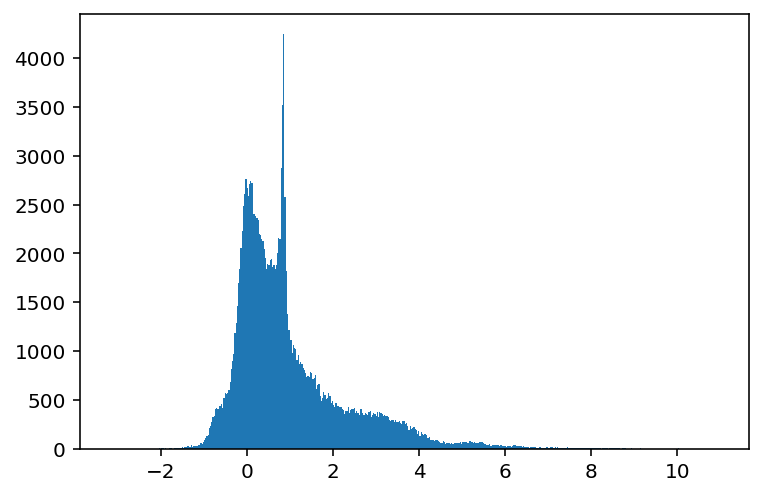

In [47]:
plt.hist(tt,bins=500)
plt.show()

In [48]:
tt = np.array(tt)

In [49]:
for d in trainlist:
    d.y = (d.y-tmean)/tsd
for d in vallist:
    d.y = (d.y-tmean)/tsd

In [50]:
tt2 = []
for d in trainlist:
    tt2.append(d.y)
for d in vallist:
    tt2.append(d.y)

In [51]:
tt2 = np.array(tt2)

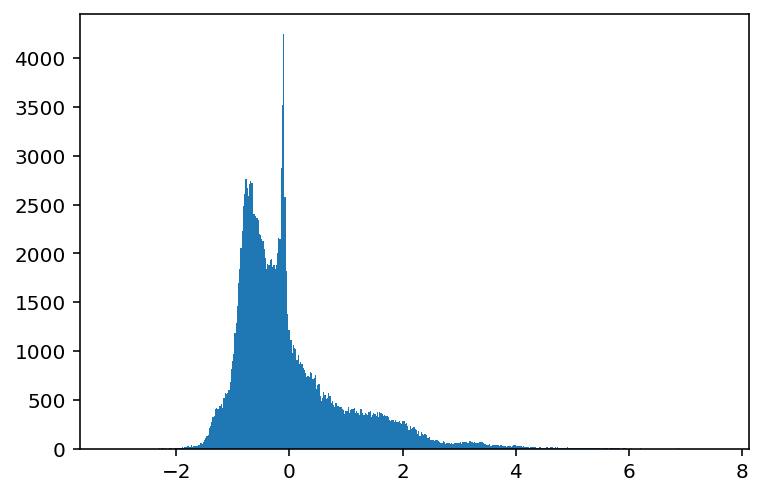

In [52]:
plt.hist(tt2,bins=500)
plt.show()

In [53]:
val_loader = DataLoader(vallist, batch_size=256,shuffle=False)
train_loader = DataLoader(trainlist, batch_size=256,shuffle=True)

In [54]:
#import gc
#del train_loader,val_loader,model
#gc.collect()
#torch.cuda.empty_cache()

In [55]:
ndim =128
edim = 64

In [56]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.lin0 = torch.nn.Linear(199, ndim)
        self.bn0 = BatchNorm1d(ndim)
        self.d0 = Dropout(0.1)
        
        nn = Sequential(Linear(31, edim), ReLU(), Linear(edim,2*edim), ReLU(),Linear(2*edim, ndim * ndim))
        self.conv = NNConv(ndim, ndim, nn, aggr='max', root_weight=True)
        self.gru = GRU(ndim, ndim)
        
        self.set2set = Set2Set(ndim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2*ndim, 192)
        self.lin2 = torch.nn.Linear(192,160)
        self.lin3 = torch.nn.Linear(160, ndim)
        self.lin4 = torch.nn.Linear(ndim, 1)

    def forward(self, data):
        out = F.selu(self.lin0(data.x))
        out = self.bn0(out)
        out = self.d0(out)
        h = out.unsqueeze(0)
        
        for i in range(3):
            m = F.selu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)
        
        out = self.set2set(out, data.batch)
        out = F.selu(self.lin1(out))
        out = F.selu(self.lin2(out))
        out = F.selu(self.lin3(out))
        out = self.lin4(out)
        
        return out.view(-1)

In [57]:
# #B2 SAVED AS T2
# xd = torch.load('Temp/t1.pth')
# model = xd['bestmodel']
# lrr = xd['lr']
# ep = 300-xd['epoch']
# ep = 150
# print('error: {}, epoch: {}'.format(xd['val_error'],ep))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# optimizer = RAdam(model.parameters(), lr=lrr,weight_decay=0.00001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = RAdam(model.parameters(), lr=0.001,weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, min_lr=0.00000001)

In [59]:
torch.cuda.empty_cache()

In [60]:
def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        #loss = torch.log(F.l1_loss(model(data),data.y)+ 4e-9)
        loss = F.l1_loss(model(data),data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)

def test(loader):
    model.eval()
    error = 0
    for data in loader:
        data = data.to(device)
        error += (model(data) * tsd - data.y * tsd).abs().sum().item()  # MAE
    return error / len(loader.dataset)

In [ ]:
best_val_error = None
bestmodel = None
for epoch in range(1, 326):
    start = time.time()
    lr = scheduler.optimizer.param_groups[0]['lr']
    loss = train(epoch)
    val_error = test(val_loader)
    scheduler.step(val_error)
    if best_val_error is None or val_error <= best_val_error:
        best_val_error = val_error
        bestmodel = deepcopy(model)
    if epoch%5 == 0:
        torch.save({'bestmodel':bestmodel,
                    'lr':lr,
                   'epoch':epoch,
                   'val_error':val_error},'Temp/t2.pth')
    end = time.time()
    print('Epoch: {:04d}, LR: {:9f},T Loss: {:.7f}, V MAE: {:.7f}, Time: {:.7f}'.format(epoch, lr, loss, val_error,end-start))

Epoch: 0001, LR:  0.001000,T Loss: 0.3609610, V MAE: 0.2856608, Time: 119.1352992
Epoch: 0002, LR:  0.001000,T Loss: 0.1657163, V MAE: 0.1815205, Time: 117.4008267
Epoch: 0003, LR:  0.001000,T Loss: 0.1311315, V MAE: 0.1633005, Time: 117.2944224
Epoch: 0004, LR:  0.001000,T Loss: 0.1139399, V MAE: 0.1490600, Time: 117.2091701


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 0005, LR:  0.001000,T Loss: 0.1035334, V MAE: 0.1208520, Time: 117.2138982
Epoch: 0006, LR:  0.001000,T Loss: 0.0941237, V MAE: 0.1138541, Time: 117.2406960
Epoch: 0007, LR:  0.001000,T Loss: 0.0880046, V MAE: 0.1127331, Time: 116.9225867
Epoch: 0008, LR:  0.001000,T Loss: 0.0824885, V MAE: 0.1084330, Time: 116.8701618
Epoch: 0009, LR:  0.001000,T Loss: 0.0795994, V MAE: 0.1028040, Time: 116.8386598
Epoch: 0010, LR:  0.001000,T Loss: 0.0765684, V MAE: 0.0971476, Time: 116.9159970
Epoch: 0011, LR:  0.001000,T Loss: 0.0719814, V MAE: 0.0949776, Time: 116.9143419
Epoch: 0012, LR:  0.001000,T Loss: 0.0688313, V MAE: 0.0925507, Time: 116.8736343
Epoch: 0013, LR:  0.001000,T Loss: 0.0673863, V MAE: 0.0891113, Time: 117.1277843
Epoch: 0014, LR:  0.001000,T Loss: 0.0643950, V MAE: 0.0875012, Time: 117.0469279
Epoch: 0015, LR:  0.001000,T Loss: 0.0621091, V MAE: 0.0844995, Time: 117.1105821
Epoch: 0016, LR:  0.001000,T Loss: 0.0604312, V MAE: 0.0853059, Time: 117.2656701
Epoch: 0017, LR:

In [ ]:
torch.save(bestmodel,'MPNN_3JHN_3FE.pth')#OG SELU AND CONNECTED TO TARGETS

In [ ]:
print('Best Validation MAE: {}'.format(best_val_error))
print('Best Log Validation MAE: {}'.format(np.log(best_val_error)))

In [ ]:
print(tmean,tsd)